In [29]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import scipy
from scipy import signal

%matplotlib inline

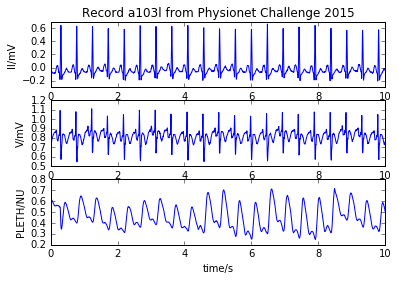

In [56]:
# SQI algorithm

# load data
# Read the wfdb file, plot the last part of the signals
sig, fields=wfdb.rdsamp('sampledata/a103l')
wfdb.plotwfdb(sig[80000:,:], fields, title='Record a103l from Physionet Challenge 2015') 

In [53]:
# find ECGs
ecg_names = ['ECG','EKG',
             'I','II','III','AVR','AVL',
             'AVF','V','V1','V2','V3','V4',
             'V5','V6','MCL1','MCL2','MCL3',
             'MCL4','MCL5','MCL6','aVR','aVL','aVF']
ecg_names = [x.lower() for x in ecg_names]
signame = fields['signame']
idxECG = np.where([x.lower() in ecg_names for x in signame])[0]
idxECG

array([0, 1])

In [57]:
# peak detect ECGs
peaks = [list() for m in range(sig.shape[1])]

# parameters - all times in seconds
integrator_window_size=11
refractory=0.250
thresh=0.5
fs=250
N_medfilt = int(np.ceil(0.1*fs))
batch_size=0 # TODO: implement batching of signal
N = sig.shape[0]

# filter used for bandpass
filter_type='ricker' # one of 'ricker','hamming'


if filter_type == 'ricker':
    bpf = 2.0*signal.ricker(41, 4.0)
# apply band-pass filter without scaling the signal

for m in idxECG:
    sig[:,m] = signal.filtfilt(bpf,1,sig[:,m])
    
    sig[0,m] = sig[1,m] - sig[0,m]
    sig[1:,m] = sig[1:,m] - sig[:-1,m]
    sig[:,m] = sig[:,m]**2
    sig[:,m] = signal.filtfilt(np.ones(integrator_window_size),1,sig[:,m])
    sig[:,m] = signal.medfilt(sig[:,m],kernel_size=N_medfilt)
    
    #? adaptive threshold?
    
    # if the signal < 20 seconds, use the 98th percentile
    if N/fs < 20:
        th = np.percentile(sig[:,m],98)
    else:
        # median of the 98th percentile in 5 segments of the signal
        th = [np.percentile( sig[np.floor(n*(N/5)):np.floor((n+1)*(N/5)),m], 98 )
             for n in range(5)]
        th = np.median(th)
        
    
    peaks[m] = sig[:,m] > (th*thresh)
    
    # TODO:search back
    

# find ABP

# peak detect ABP

# find PPG

# peak detect PPG

/home/alistair/.local/lib/python2.7/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


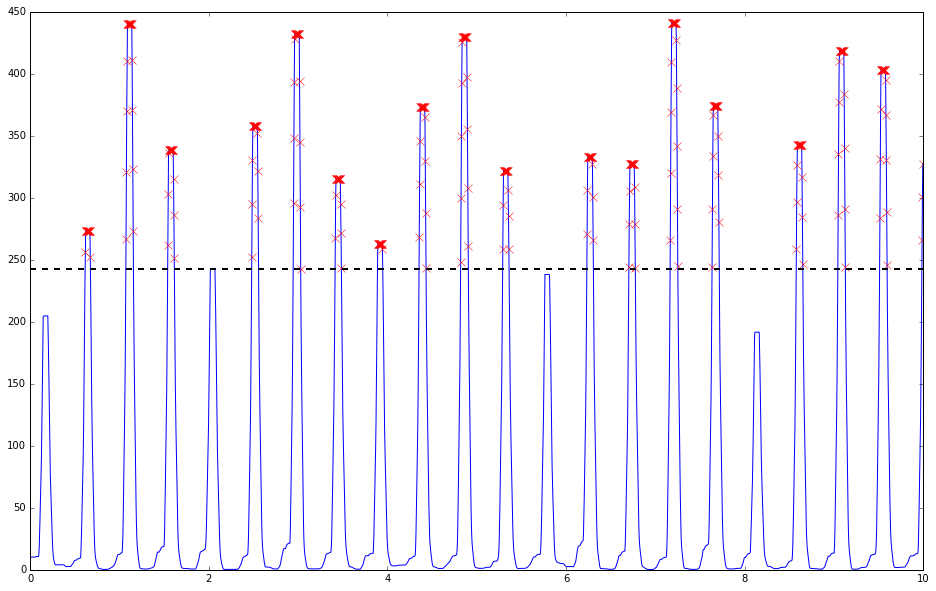

In [76]:
m=1

t_end=10
t=np.asarray(range(sig.shape[0])).astype(float)/fs
idxPeak = np.where(peaks[m][0:fs*t_end])


plt.figure(figsize=[16,10])
plt.plot(t[0:fs*t_end],sig[0:fs*t_end,m],'b-')
plt.plot(t[idxPeak],np.squeeze(sig[idxPeak,m]),'rx',markersize=8)
plt.plot([0,t_end],[th*thresh,th*thresh],'k--',linewidth=2)
plt.show()